In [5]:
import matplotlib.pyplot as plt

./test-rotated-5.jpg
(408, 612, 3)
Image_original


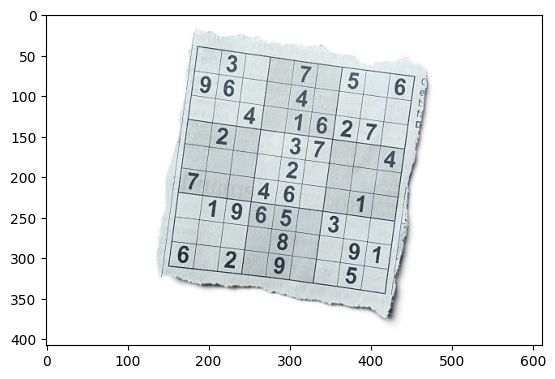

Image_preprocessed


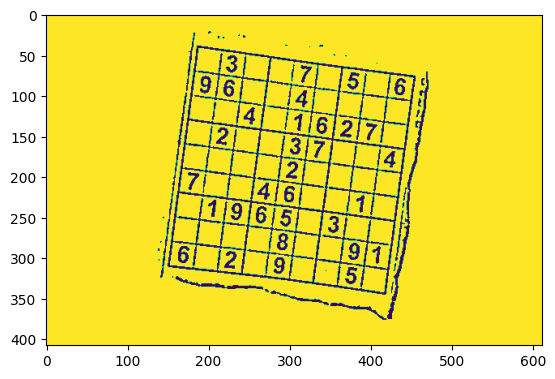

Contour  0 0.294656302063309 center (302, 192)


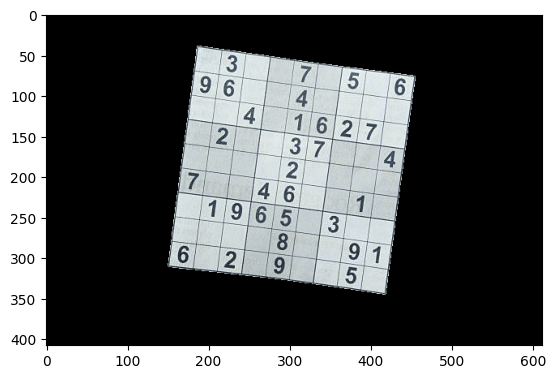

Contour found: origin has 292 points


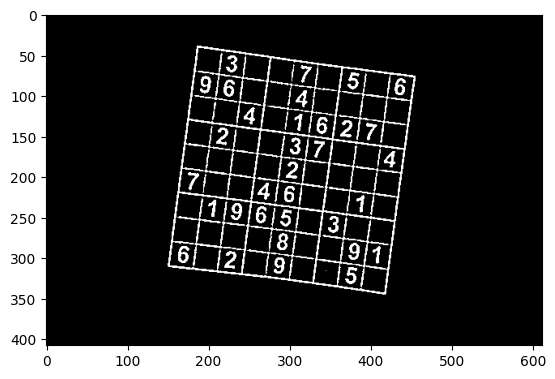

4-pnt corners:
 [[[186  39]]

 [[150 310]]

 [[418 345]]

 [[455  76]]]
Sorted corners:
 [array([[186,  39]], dtype=int32), array([[455,  76]], dtype=int32), array([[418, 345]], dtype=int32), array([[150, 310]], dtype=int32)]


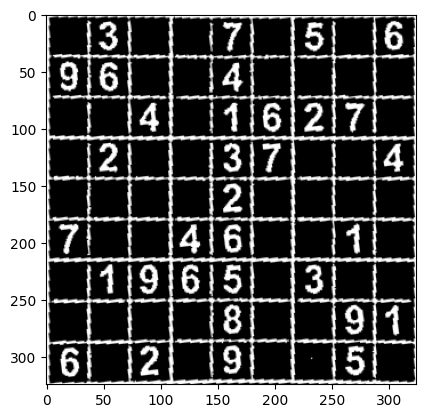

Image_extracted


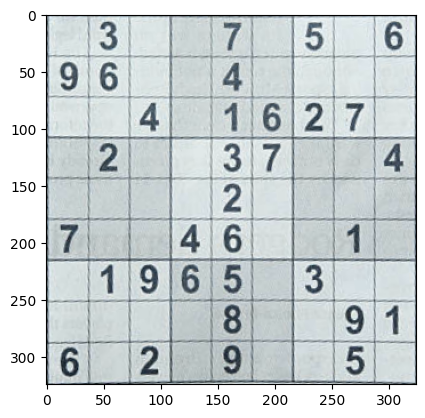

Extracted image preprocessed


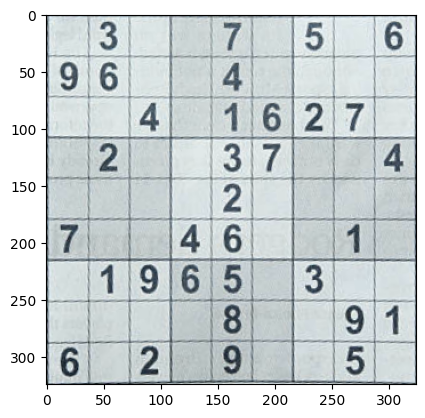

1/1 [==============================] - 2s 2s/step
[[10  3  7  7  7  7  5  7  6]
 [ 5  6  7 10  4  7  7  7  7]
 [10 10  4 10  1  6  2  7  7]
 [ 6  2  7 10  3  7  7  7  4]
 [ 0  0  4  0  2  2  2  7  2]
 [ 7  2  2  4  6  2  2  1  2]
 [ 0  1  9  6  5  2  3  2  2]
 [ 0  2  2  2  8  2  2  9  1]
 [ 6  0  2  2  8  2  2  5  2]]
_ 3 7 7 7 7 5 7 6 
5 6 7 _ 4 7 7 7 7 
_ _ 4 _ 1 6 2 7 7 
6 2 7 _ 3 7 7 7 4 
_ _ 4 _ 2 2 2 7 2 
7 2 2 4 6 2 2 1 2 
_ 1 9 6 5 2 3 2 2 
_ 2 2 2 8 2 2 9 1 
6 _ 2 2 8 2 2 5 2 
True
True
True
False


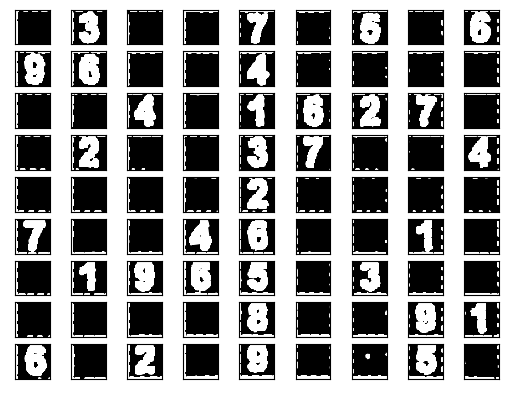

In [6]:
## General libraries
import sys, os, time
import numpy as np
import logging

import cv2 as cv
import keras
import keras_ocr    ## OCR library for number recognition
import string


class ImageContours():
    def __init__(self, image) -> None:
        self.ContoursList = []
        self.foundedContours = []   # list: founded contours
        self.setImage(image)
        pass

    def setImage(self, image):
        """Load image and analyze contours in it

        Args:
            image (cv Image BW): image to load
        """
        self.Image = image.copy()
        h,w = np.shape(self.Image)[:2]
        self.imageArea = h*w
        self._FindContours()

    def _FindContours(self):
        minArea = 0.0005 * self.imageArea
        # findContours
        self.foundedContours, _ = cv.findContours(self.Image, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
        ## Exclude very small contours
        self.limitContoursWithArea()



    def limitContoursWithArea(self, minArea=0.0005, maxArea=1):
        if minArea < 0.0005:
            minArea = 0.0005
        if maxArea > 1 or maxArea < minArea:
            maxArea = 1
        minArea = minArea * self.imageArea
        maxArea = maxArea * self.imageArea
        newList = []
        for i, cnt in enumerate(self.foundedContours):
            ar = cv.contourArea(cnt)
            if ar >= minArea and ar <= maxArea:
                newList.append(cnt)
        newList = sorted(newList, key=cv.contourArea, reverse=True)
        self.foundedContours = tuple(newList)


    def getContourNumber(self):
        """Return number of contours detected in image. Note: not all contours could present in list, very small contours dropped.

        Returns:
            int: Number of contours.
        """
        return len(self.foundedContours)

    def getContour(self, contourNumber):
        """return contour from detected contours by number

        Args:
            contourNumber (int): number of contour to return. (from list of contours)

        Returns:
            list: contour
        """
        try:
            contour = self.foundedContours[contourNumber]
        except:
            contour = None
        return contour
    
    def getContourArea(self, contourNumber):
        """Get contour area (in term of openCV)

        Args:
            contourNumber (int): number of contour to return. (from list of contours)

        Returns:
            int: contour area
        """
        contour = self.getContour(contourNumber)
        if contour is None:
            return 0
        area = cv.contourArea(contour)
        return area

    def getContourCenter(self, contourNumber):
        """Get contour geometrical center

        Args:
            contourNumber (int): number of contour to return. (from list of contours)

        Returns:
            tuple: (x, y) contour center related to image containing contour
        """
        x, y = -1, -1
        contour = self.getContour(contourNumber)
        if contour is None:
            return (x, y)
        M = cv.moments(contour)
        if M['m00'] != 0.0:
            x = int(M['m10']/M['m00'])
            y = int(M['m01']/M['m00']) 
        return (x, y)



    def ExtractContour(self, contourNumber, imageFrom = None, cropped = False):
        """Extract contour from image.

        Args:
            contourNumber (int): number of contour to return. (from list of contours)
            imageFrom (cv Image, optional): Image for contour extraction. Defaults to None, use image from which contours extracted.
            cropped (bool, optional): Extcract only contour-sized image. Defaults to False. Full size image extracted.

        Returns:
            cv Image: Extracted contour.
        """
        
        if imageFrom is None:
            imageFrom = self.Image
        try:
            deep = np.shape(imageFrom)[2]
        except:
            deep = 1            
        color = tuple([255]*deep)
        mask = np.zeros(np.shape(imageFrom), dtype = 'uint8')
        imageExtracted = np.zeros(np.shape(imageFrom), dtype = 'uint8')
        try:
            contour = self.foundedContours[contourNumber]
            cv.drawContours(
                image=mask,
                contours=[contour],
                contourIdx=-1,
                color=color,
                thickness=cv.FILLED)
            mask = mask.astype(bool)
            np.copyto(src=imageFrom, dst=imageExtracted, where=mask)
            if cropped:
                X ,Y, W, H = cv.boundingRect(contour)
                imageExtracted = imageExtracted[Y:Y+H, X:X+W]
        except:
            pass
        return imageExtracted

    def _uniqueColors(self, pixelsList):
        """return list of unique colors in list of pixels

        Args:
            pixelsList (list): list of pixels [r,g,b] to calculate in

        Returns:
            tuple: (list_colors, list_count) list of unique colors and count of each color
        """
        # intilize a null list
        unique_list = []
        unique_count = []
        # traverse for all elements
        for x in pixelsList:
            # check if exists in unique_list or not
            if x not in unique_list:
                unique_list.append(x)
                unique_count.append(0)
            unique_count[unique_list.index(x)] += 1
        return (unique_list, unique_count)    
    
    def getContourColor(self, contourNumber, imageFrom = None):
        """get the color of contour (most present in image)

        Args:
            contourNumber (int): number of contour to return. (from list of contours)
            imageFrom (cv Image, optional): RGB image to use for contour color. Defaults to None (contour detection image)

        Returns:
            list: color elements r,g,b (or in sequence of original image)
        """
        if imageFrom is None:
            imageFrom = self.Image
        contour = self.getContour(contourNumber)
        if contour is None:
            return None
        cimg = self.ExtractContour(contourNumber, imageFrom=imageFrom)
        cimgf = cv.medianBlur(cimg, ksize=9)
        (x,y,d) = cimgf.shape
        pixels = cimgf.reshape( x*y  , d).tolist()
        unique, counts = self._uniqueColors(pixels)
        maxcs = [counts.index(i) for i in sorted(counts, reverse=True)][:3]
        ## skip black backgrounds
        if np.array_equal([0,0,0],  unique[0]) :
            colorindex = min(1, len(maxcs)-1)
        else:
            colorindex = 0
        color = unique[maxcs[colorindex]]
        return color
    







class SudokuRecognition():
    # OCRpipeline = keras_ocr.pipeline.Pipeline()
    PREDICT_MODEL = keras.models.load_model('model_font_28x28x1'+'.h5')
    #PREDICT_MODEL = keras.models.load_model('model_mnist'+'.h5')
    PREDICT_CLASSES = list("0123456789_")
    def __init__(self, fname, size=9):
        self.filename = fname
        self.Size = size
        self.Image_original = None      ## Original:    color
        self.Image_preprocessed = None  ## Preprocessed: color
        self.Image_extracted = None     ##
        self.Image_recognized = None

        self.f_image_loaded = False
        self.f_image_preprocessed = False
        self.f_image_extracted = False    ## table extracted
        self.f_image_recognized = False   ## table digits recognized
#        self.image_solved = False       ##
        self.Board = None   ## board of recognized numbers
        print(self.filename)

    def image_load(self):
        img = cv.imread(self.filename, cv.IMREAD_COLOR)
        if img is not None:
            print(img.shape)
            newim = np.zeros((img.shape[0]+2, img.shape[1]+2, img.shape[2]) , dtype=np.uint8) 
            newim.fill(255)
            newim[1:-1, 1:-1] = img[0:, 0:]
            self.Image_original = img
            self.f_image_loaded = True
            return True
        else:
            print("Error loading image")
        return False

    def image_preprocess(self, image, wiping = 1):
        if wiping > 3 or wiping < 0:
            wiping = 3
        try:
            deep = image.shape[2]
        except:
            deep = 1
        if deep == 1:
            gray = image.copy()
        else:
            gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
        gray = cv.GaussianBlur(gray, (5, 5), 0)
        thresh = cv.adaptiveThreshold(gray, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 11, wiping * 7)
        return thresh

    def _extract_table_corners(self, image):
        Contours = ImageContours(image)
        Contours.limitContoursWithArea(0.2)
        if Contours.getContourNumber() == 0:
            return False
        for i in range(Contours.getContourNumber()):
            print('Contour ', i, Contours.getContourArea(i) / Contours.imageArea,'center', Contours.getContourCenter(i))
            plt.imshow(Contours.ExtractContour(i, imageFrom=self.Image_original))
            plt.show()
            cnt = Contours.getContour(i)
            peri = cv.arcLength(cnt, True)
            approx = cv.approxPolyDP(cnt, 0.05 * peri, True) ## tight !!!
            if len(approx) == 4:
                print(f"Contour found: origin has {len(cnt)} points")
                # Here we are looking for the largest 4 sided contour
                imgc = Contours.ExtractContour(i, image)
                plt.imshow(imgc, cmap='gray')
                plt.show()
                return approx
        return None
    
    def _sort_contours(self, cnts, method="left-to-right"):
        """Taken from https://github.com/PyImageSearch/imutils/blob/master/imutils/contours.py#L7
        and """
        # initialize the reverse flag and sort index
        reverse = False
        i = 0
        # handle if we need to sort in reverse
        if method == "right-to-left" or method == "bottom-to-top":
            reverse = True
        # handle if we are sorting against the y-coordinate rather than
        # the x-coordinate of the bounding box
        if method == "top-to-bottom" or method == "bottom-to-top":
            i = 1
        # construct the list of bounding boxes and sort them from top to
        # bottom
        boundingBoxes = [cv.boundingRect(c) for c in cnts]
        (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
                                            key=lambda b: b[1][i], reverse=reverse))

        # return the list of sorted contours and bounding boxes
        return cnts, boundingBoxes
    
    def __sort_rectangle_corners(self, Contour):
        if len(Contour) != 4:
            ## log warning
            return Contour
        tops = list(sorted([*Contour], key=lambda cp: cp[0][1], reverse=False)[:2] )# top to bottom
        bottoms = list(sorted([*Contour], key=lambda cp: cp[0][1], reverse=True)[:2]) # bottom to top
        tops = sorted([*tops], key=lambda cp: cp[0][0], reverse=False) #tops from left to right
        bottoms = sorted([*bottoms], key=lambda cp: cp[0][0], reverse=True) #bottoms from left to right
        return list([*tops, *bottoms])


    def table_image_extract(self):
        img = self.Image_preprocessed
        imgInverted = cv.bitwise_not(img)   ## invert image for contour recognition
        corners = self._extract_table_corners(imgInverted)
        if corners is None:
            return False
        print("4-pnt corners:\n", corners)
        corners = self.__sort_rectangle_corners(corners)
        print("Sorted corners:\n", corners)
        width = height = self.Size * (28 + 4*2)
        marker_coordinates = np.float32(corners)
        true_coordinates   = np.float32([[0,0],[width,0],[width,height],[0,height]])
        try:
            trans_mat = cv.getPerspectiveTransform(marker_coordinates,true_coordinates)
            img_trans = cv.warpPerspective(imgInverted,trans_mat,(width, height))
            ##cv.imshow('Converted', img_trans)
            self.Image_extracted_Inv = img_trans
            plt.imshow(img_trans, cmap='gray')
            plt.show()
            imgTable = cv.warpPerspective(self.Image_original,trans_mat,(width, height))
        except:
            return False
            pass
        self.Image_extracted = imgTable
        self.f_image_extracted = True
        return True
    
    def extract_digits(self, imageBW, imageExctract):

        imgs = []
        try:
            deep = imageExctract.shape[2]
            image = cv.cvtColor(imageExctract, cv.COLOR_BGR2GRAY)
        except:
            deep = 1
            image = imageExctract.copy()
        image = image / 255.0     ## 888 image
        H,W = np.shape(imageBW)[:2]
        h = H/self.Size
        w = W/self.Size
        fig = plt.figure()
        for r in range(0, self.Size):
            for c in range(0, self.Size):
                MS = 28+4
                x0 = int(w/2 + c*W/self.Size - MS/2)     ## mnist model size 28
                y0 = int(h/2 + r*H/self.Size - MS/2)     ## mnist model size 28
                dimg = image[y0:y0+MS, x0:x0+MS]
                # C = ImageContours(dimg)
                # C.limitContoursWithArea(0.03,  0.5)
                # if C.getContourNumber() == 0:
                #     ## empty image
                #     dimg = dimg.fill(0)
                # else:
                #     cimg = C.ExtractContour(0)

                #     #dimg = ##cv.boundingRect(C.getContour(0))
                dimg = cv.resize(dimg, (28, 28), interpolation=cv.INTER_AREA)
                dimg = dimg.reshape( 28, 28, 1).astype('float32')
                imgs.append(dimg)
                ## +++
                plt.subplot(self.Size, self.Size, r*self.Size+c+1)
                plt.imshow(dimg, cmap='gray', vmin=0, vmax=1)
                plt.xticks([]); plt.yticks([])
                ## ---
        # plt.show()
        return imgs


    def image_recognize(self):
        img = self.Image_extracted
        #img = self.image_preprocess(image=img, wiping=1) # contours way
        print("Extracted image preprocessed")
        plt.imshow(img, cmap='gray')
        plt.show()


        board = np.zeros((self.Size, self.Size), dtype=np.uint8)

        ### +++ OCR full img
        # # plot the text predictions
        # imgAnnot = img.copy()
        # images = [img]
        # alphabet = string.digits
        # prediction_groups = __class__.OCRpipeline.recognize(images)
        # keras_ocr.tools.drawAnnotations(image=imgAnnot, predictions=prediction_groups[0], )
        # plt.imshow(imgAnnot)
        # plt.show()
        ### ---

        ### +++ own "mnist-like" recognition
        np.set_printoptions(precision=3, suppress=True)
        images = self.extract_digits(self.Image_extracted_Inv, self.Image_extracted_Inv)
        request = np.vstack(images)
        request = np.array(images)
        pred = __class__.PREDICT_MODEL.predict(request, batch_size=self.Size * self.Size)
        # print(pred)
        maxpred = np.argmax(pred, axis=1)
        board = maxpred.reshape(self.Size, self.Size)
        # print(zip(* [[x if 0<x<10 else ' ' for x in l] for l in list(board)]) )
        print(board)
        for l in board:
            for x in l:
                print(x, end=' ') if 0<x<10 else print('_',end=' ')
            print()
        

        ### ---

        return False







        



    def recognize(self):
        if not self.image_load():
            return False
        print("Image_original")
        plt.imshow(self.Image_original)
        plt.show()
        
        self.Image_preprocessed = self.image_preprocess(image = self.Image_original)
        self.f_image_preprocessed = True

        print("Image_preprocessed")
        plt.imshow(self.Image_preprocessed)
        plt.show()

        if not self.table_image_extract():
            return False
        print("Image_extracted")
        plt.imshow(self.Image_extracted)
        plt.show()
        if not self.image_recognize():
            return False
        print("Image_recognized")
        plt.imshow(self.Image_recognized)
        plt.show()
        return True


# if __name__=="__main__":
#     abspath = os.path.abspath(__file__)
#     dname = os.path.dirname(abspath)
#     os.chdir(dname)
fname = "./test-rotated-5.jpg"
#fname = "./test2-bw-noise.png"
# fname = "./test3-hard.jpg"
# fname = "./test8.jpg"
# fname = "./test4.png"
sudoku = SudokuRecognition(fname)

if sudoku.recognize():
    print(sudoku.Board)

print(sudoku.f_image_loaded)
print(sudoku.f_image_preprocessed)
print(sudoku.f_image_extracted)
print(sudoku.f_image_recognized)

